In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torchvision import datasets, transforms

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

## Task 2.2

In [3]:
batch_size = 128
np.random.seed(0)
torch.manual_seed(0)
transform = transforms.Compose([
    transforms.ToTensor()
])
permutation = torch.randperm(32 * 32 * 3)

train_dataset = datasets.ImageFolder('../data/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.ImageFolder('../data/test', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

def permute_images(dataset, permutation):
    permuted_dataset = []
    for image, label in tqdm(dataset):
        permuted_image = image.view(-1, 32 * 32 * 3)[:, permutation].view_as(image)
        permuted_dataset.append((permuted_image, label))
    return permuted_dataset

permuted_train_dataset = permute_images(train_dataset, permutation)
permuted_test_dataset = permute_images(test_dataset, permutation)
permuted_train_loader = DataLoader(permuted_train_dataset, batch_size=batch_size, shuffle=True)
permuted_test_loader = DataLoader(permuted_test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [00:01<00:00, 6070.31it/s]


In [4]:
def train_and_plot(network, train_loader, test_loader, epochs=50, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(network.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

    epoch_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        print("epoch:", epoch)
        network.train()
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)

        # eval mode
        network.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = network(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        scheduler.step(test_loss)
        average_test_loss = test_loss / len(test_loader)
        test_losses.append(average_test_loss)
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        print("test accuracy:", test_accuracy)
        print("test loss:", average_test_loss)

    # Print the final results
    print(f"Finished Training\nParameters: {sum(p.numel() for p in network.parameters())}")
    print(f"Final Training Loss: {epoch_losses[-1]:.4f}")
    print(f"Final Test Loss: {test_losses[-1]:.4f}")
    print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

    # Plotting Training and Test Losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return epoch_losses, test_losses, test_accuracies, network

In [5]:
class PlainNet18Corrected(nn.Module):
    def __init__(self, num_classes=10):
        super(PlainNet18Corrected, self).__init__()
        
        self.in_planes = 64 

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
                        nn.Linear(512, 1000),
                        nn.Linear(1000, num_classes))

    def _make_layer(self, planes, blocks, stride):
        layers = []
        
        for _ in range(0, blocks):
            layers.append(nn.Conv2d(self.in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(planes))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(planes))
            layers.append(nn.ReLU(inplace=True))
            self.in_planes = planes
            stride = 1 

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        # print("1", x.shape) # 1 torch.Size([128, 64, 16, 16])
        x = self.initial_pool(x)
        # print("2", x.shape) # 2 torch.Size([128, 64, 8, 8])
        x = self.layer1(x)
        # print("3", x.shape) # 3 torch.Size([128, 64, 8, 8])
        x = self.layer2(x)
        # print("4", x.shape) # 4 torch.Size([128, 128, 4, 4])
        x = self.layer3(x)
        # print("5", x.shape) # 5 torch.Size([128, 256, 2, 2])
        x = self.layer4(x)
        # print("6", x.shape) # 6 torch.Size([128, 512, 1, 1])
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

plain_net_18_corrected = PlainNet18Corrected().to(device)

ModifiedResNet18


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 0


  2%|▏         | 1/50 [00:13<11:25, 13.99s/it]

test accuracy: 48.28
test loss: 1.4217705138121979
epoch: 1


  4%|▍         | 2/50 [00:25<09:52, 12.34s/it]

test accuracy: 56.49
test loss: 1.2266140014310427
epoch: 2


  6%|▌         | 3/50 [00:36<09:16, 11.84s/it]

test accuracy: 55.23
test loss: 1.2627987635286548
epoch: 3


  8%|▊         | 4/50 [00:47<08:53, 11.59s/it]

test accuracy: 61.69
test loss: 1.0982511149177068
epoch: 4


 10%|█         | 5/50 [00:58<08:36, 11.48s/it]

test accuracy: 61.48
test loss: 1.139320597618441
epoch: 5


 12%|█▏        | 6/50 [01:10<08:20, 11.38s/it]

test accuracy: 62.54
test loss: 1.151105959958668
epoch: 6


 14%|█▍        | 7/50 [01:21<08:06, 11.32s/it]

test accuracy: 62.95
test loss: 1.174278839479519
epoch: 7


 16%|█▌        | 8/50 [01:31<07:45, 11.08s/it]

test accuracy: 62.02
test loss: 1.2235382938686805
epoch: 8


 18%|█▊        | 9/50 [01:43<07:37, 11.15s/it]

test accuracy: 62.77
test loss: 1.2542145531388778
epoch: 9


 20%|██        | 10/50 [01:54<07:25, 11.15s/it]

test accuracy: 64.4
test loss: 1.25744304475905
epoch: 10


 22%|██▏       | 11/50 [02:05<07:12, 11.09s/it]

test accuracy: 61.61
test loss: 1.4365467534789556
epoch: 11


 24%|██▍       | 12/50 [02:16<07:00, 11.07s/it]

test accuracy: 62.69
test loss: 1.4485065718240375
epoch: 12


 26%|██▌       | 13/50 [02:27<06:52, 11.15s/it]

test accuracy: 63.3
test loss: 1.455471231967588
epoch: 13


 28%|██▊       | 14/50 [02:38<06:42, 11.18s/it]

test accuracy: 63.46
test loss: 1.5085403021377852
epoch: 14


 30%|███       | 15/50 [02:50<06:31, 11.20s/it]

test accuracy: 63.62
test loss: 1.5675267026394228
epoch: 15


 32%|███▏      | 16/50 [03:00<06:15, 11.05s/it]

test accuracy: 66.3
test loss: 1.5063967983933944
epoch: 16


 34%|███▍      | 17/50 [03:11<06:05, 11.09s/it]

test accuracy: 66.55
test loss: 1.63900961076157
epoch: 17


 36%|███▌      | 18/50 [03:22<05:52, 11.02s/it]

test accuracy: 66.43
test loss: 1.7586097656926023
epoch: 18


 38%|███▊      | 19/50 [03:33<05:42, 11.04s/it]

test accuracy: 66.47
test loss: 1.845207929611206
epoch: 19


 40%|████      | 20/50 [03:45<05:33, 11.11s/it]

test accuracy: 66.32
test loss: 1.93440320823766
epoch: 20


 42%|████▏     | 21/50 [03:56<05:20, 11.05s/it]

test accuracy: 66.1
test loss: 2.007884686506247
epoch: 21


 44%|████▍     | 22/50 [04:07<05:08, 11.00s/it]

test accuracy: 66.48
test loss: 2.076776353618767
epoch: 22


 46%|████▌     | 23/50 [04:17<04:54, 10.92s/it]

test accuracy: 66.06
test loss: 2.1685891845558265
epoch: 23


 48%|████▊     | 24/50 [04:28<04:42, 10.87s/it]

test accuracy: 66.53
test loss: 2.1836021278477924
epoch: 24


 50%|█████     | 25/50 [04:39<04:32, 10.90s/it]

test accuracy: 66.0
test loss: 2.2506348875504507
epoch: 25


 52%|█████▏    | 26/50 [04:50<04:22, 10.93s/it]

test accuracy: 66.04
test loss: 2.297416211683539
epoch: 26


 54%|█████▍    | 27/50 [05:01<04:12, 10.96s/it]

test accuracy: 66.41
test loss: 2.258874389189708
epoch: 27


 56%|█████▌    | 28/50 [05:12<04:00, 10.95s/it]

test accuracy: 66.55
test loss: 2.2581130401997624
epoch: 28


 58%|█████▊    | 29/50 [05:23<03:50, 10.99s/it]

test accuracy: 66.43
test loss: 2.248645936386495
epoch: 29


 60%|██████    | 30/50 [05:34<03:40, 11.04s/it]

test accuracy: 66.37
test loss: 2.266255840470519
epoch: 30


 62%|██████▏   | 31/50 [05:45<03:29, 11.03s/it]

test accuracy: 66.42
test loss: 2.2676060003570364
epoch: 31


 64%|██████▍   | 32/50 [05:56<03:18, 11.04s/it]

test accuracy: 66.36
test loss: 2.26580581182166
epoch: 32


 66%|██████▌   | 33/50 [06:07<03:07, 11.03s/it]

test accuracy: 66.42
test loss: 2.2818693843068956
epoch: 33


 68%|██████▊   | 34/50 [06:18<02:54, 10.90s/it]

test accuracy: 66.39
test loss: 2.299497937854332
epoch: 34


 70%|███████   | 35/50 [06:29<02:43, 10.92s/it]

test accuracy: 66.56
test loss: 2.301370767098439
epoch: 35


 72%|███████▏  | 36/50 [06:40<02:34, 11.03s/it]

test accuracy: 66.7
test loss: 2.3176878358744366
epoch: 36


 74%|███████▍  | 37/50 [06:51<02:24, 11.09s/it]

test accuracy: 66.45
test loss: 2.3294016998025437
epoch: 37


 76%|███████▌  | 38/50 [07:02<02:13, 11.10s/it]

test accuracy: 66.49
test loss: 2.339706343940542
epoch: 38


 78%|███████▊  | 39/50 [07:14<02:03, 11.20s/it]

test accuracy: 66.53
test loss: 2.32721342014361
epoch: 39


 80%|████████  | 40/50 [07:25<01:52, 11.25s/it]

test accuracy: 66.47
test loss: 2.3297976013980333
epoch: 40


 82%|████████▏ | 41/50 [07:36<01:40, 11.18s/it]

test accuracy: 66.6
test loss: 2.3256570462939106
epoch: 41


 84%|████████▍ | 42/50 [07:47<01:28, 11.11s/it]

test accuracy: 66.44
test loss: 2.3418534647060345
epoch: 42


 86%|████████▌ | 43/50 [07:58<01:17, 11.01s/it]

test accuracy: 66.69
test loss: 2.330217719078064
epoch: 43


 88%|████████▊ | 44/50 [08:09<01:05, 10.95s/it]

test accuracy: 66.55
test loss: 2.3314583241185054
epoch: 44


 90%|█████████ | 45/50 [08:20<00:55, 11.04s/it]

test accuracy: 66.54
test loss: 2.341115506389473
epoch: 45


 92%|█████████▏| 46/50 [08:31<00:44, 11.06s/it]

test accuracy: 66.66
test loss: 2.3488249673119075
epoch: 46


 94%|█████████▍| 47/50 [08:42<00:33, 11.11s/it]

test accuracy: 66.7
test loss: 2.342810519133942
epoch: 47


 96%|█████████▌| 48/50 [08:54<00:22, 11.11s/it]

test accuracy: 66.53
test loss: 2.322942886171462
epoch: 48


 98%|█████████▊| 49/50 [09:04<00:10, 10.90s/it]

test accuracy: 66.58
test loss: 2.329593317418159
epoch: 49


100%|██████████| 50/50 [09:10<00:00, 11.02s/it]

test accuracy: 66.68
test loss: 2.3358899460563176
Finished Training
Parameters: 11525698
Final Training Loss: 0.0010
Final Test Loss: 2.3359
Final Test Accuracy: 66.68%


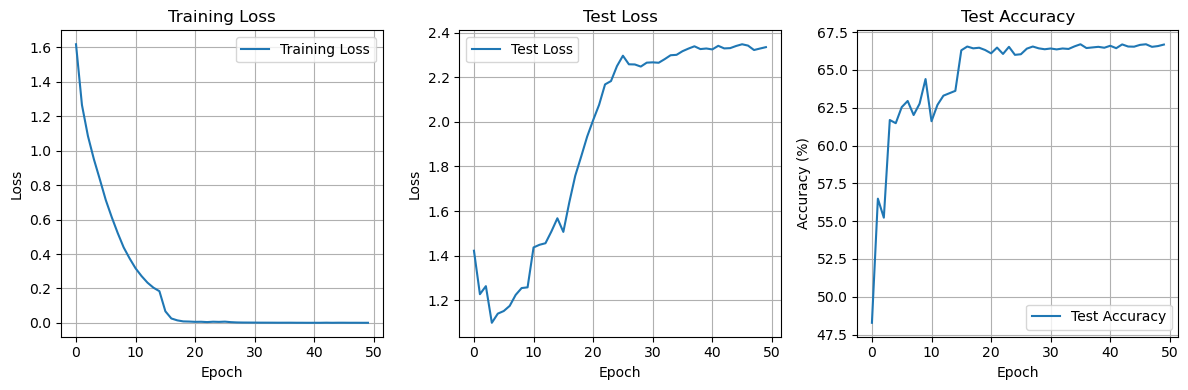

In [6]:
print("ModifiedResNet18")
training_losses1, testing_losses1, acc1, network1 = train_and_plot(plain_net_18_corrected, train_loader, test_loader)

Q: Please make a report of your observations. Compare RESNET-18 performance on the permuted dataset. If you find any drop in performance, can you explain the reason?

A: Comparing the above (permuted dataset) with the Task 2.1 (original dataset without permutation), we can see that there is a slight difference between the test accuracy and test loss. They are almost the same.
This is because convolutional filters are translation-invariant. Since the same permutation is applied to every image, the CNN can still capture local patterns.
